In [15]:
using Plots
using TensorCrossInterpolation, LinearAlgebra
using QuanticsTCI
using QuanticsGrids
using ITensorMPS
using ITensors
using NDTensors
using TCIITensorConversion
using IterativeSolvers
using LinearMaps
using LinearAlgebra
include("src/differential_mpo.jl")

get_c_vec (generic function with 1 method)

In [33]:
# simulation parameter

R = 3
tol = 1e-8
max_bond = 5
delta_t = 0.1 * 2.0^-(R-1)
v = 1e-5
penalty_coefficient = 2.5e5


# starting conditions and boundaries

a = 2
xmin = -10
xmax = 10
ymin = -10
ymax = 10
dx = float(abs(xmin - xmax) / (2^R-1))
dy = float(abs(ymin - ymax) / (2^R-1))

function u_1(x,y)
    return exp(-(((x/a)^2/2) + ((y/a)^2)/2))
end
function u_2(x,y)
    return exp(-(((x/a)^2/2) + ((y/a)^2)/2))
end

u_2 (generic function with 1 method)

In [34]:
# QuanticsTCI
qgrid = DiscretizedGrid{2}(R, (xmin, ymin), (xmax, ymax); includeendpoint = true)
u1q, ranks1, errors1 = quanticscrossinterpolate(Float64, u_1, qgrid; maxbonddim=max_bond)
u2q, ranks2, errors2 = quanticscrossinterpolate(Float64, u_2, qgrid; maxbonddim=max_bond)

# Convert to MPS Format
s = siteinds("Qudit", R, dim=4)
u = [ITensorMPS.MPS(TensorTrain(u1q.tci), sites=s), ITensorMPS.MPS(TensorTrain(u2q.tci), sites=s)]
u_p = deepcopy.(u)

# Build Diff MPOs
d1 = [Diff_1_8_x(dx, s), Diff_1_8_y(dy, s)]
d2 = [Diff_2_8_x(dx, s), Diff_2_8_y(dy, s)]
del = MPO([delta(s[i], s[i]', s[i]'') for i in 1:length(s)])
print("Done!")

Done!

In [35]:
center = 2
u = orthogonalize.(u, center)
u_p = orthogonalize.(u_p, center)
c_vec = get_c_vec(u_p, center)
beta = make_beta(u, u_p, center, delta_t, v, d1, d2, del, max_bond)

function A_function(c_vec)
    return c_vec - penalty_coefficient * delta_t^2 * apply_H(c_vec, u_p, d1, center, max_bond)
end
d = sum(length.(array.(getindex.(u_p, center))))
A = FunctionMap{Float64,false}(A_function, d)

128×128 FunctionMap{Float64,false}(A_function; issymmetric=false, ishermitian=false, isposdef=false)

In [32]:
A_dense = Matrix(A)

128×128 Matrix{Float64}:
  25.4471       -11.1111        2.0069e-16   …  -0.0700107     -1.44466
  -4.91958e-16    1.0          -6.57607e-31     -4.45143       -0.134562
  -8.96923e-16    5.9889e-15    1.0              0.211973       4.37402
  -2.22492      -11.1111        1.49559e-16      1.47022        0.0444433
 -11.1111        24.4471        6.61917e-17      0.0444433     -0.0700107
   4.1867e-16     3.38219e-16   2.25995e-30  …   4.37402       -4.45143
   3.82575e-16    7.75548e-16  -1.97836e-31     -0.134562       0.211973
 -11.1111        -2.22492       1.1443e-16      -1.44466        1.47022
  -9.56572e-17   -1.28202e-16  24.4471          -0.14906       -3.07583
   1.5887e-32    -7.05918e-32  -2.01151e-15     -0.14906       -0.00450593
   ⋮                                         ⋱                
  -3.07583       -0.14906       4.37402          4.35953e-15  -11.1111
   1.47022       -1.44466       3.13027      …   6.14306e-15    2.00894e-15
   0.211973      -0.134562      0.00

In [28]:
eigs = eigvals(A_dense)
eigs / maximum(real(eigs))

320-element Vector{ComplexF64}:
 -0.35053299324658943 - 0.12657213658474575im
 -0.35053299324658943 + 0.12657213658474575im
  -0.3074949733853383 + 0.0im
  -0.2839811074891759 - 0.3194148292574736im
  -0.2839811074891759 + 0.3194148292574736im
 -0.23912532918699622 - 0.08684954339946137im
 -0.23912532918699622 + 0.08684954339946137im
 -0.22563398744476285 + 0.0im
 -0.16970396016116981 - 0.30374077689838686im
 -0.16970396016116981 + 0.30374077689838686im
                      ⋮
  0.43548747981250785 + 0.04733139701268201im
   0.4536637986344166 - 0.28112145458142285im
   0.4536637986344166 + 0.28112145458142285im
   0.5594348682720441 - 0.10133313256658492im
   0.5594348682720441 + 0.10133313256658492im
   0.5753364179271665 + 0.0im
    0.610598606047963 - 0.05758446841301105im
    0.610598606047963 + 0.05758446841301105im
                  1.0 + 0.0im

In [ ]:
center = 2
u = orthogonalize.(u, center)
u_p = orthogonalize.(u_p, center)
c_vec = get_c_vec(u_p, center)
beta = make_beta(u, u_p, center, delta_t, v, d1, d2, del, max_bond)

function A_function(c_vec)
    return c_vec - penalty_coefficient * delta_t^2 * apply_H(c_vec, u_p, d1, center, max_bond)
end
d = sum(length.(array.(getindex.(u_p, center))))
A = FunctionMap{Float64,false}(A_function, d)

cg!(c_vec, A, beta, abstol=1e-6, reltol=0, verbose=true, maxiter=100)

place_c_vec!(u_p, c_vec, center)

  1	2.36e+09
  2	5.56e+09
  3	9.89e+09
  4	1.51e+10
  5	2.12e+10
  6	2.80e+10
  7	3.56e+10
  8	4.40e+10
  9	5.30e+10
 10	6.27e+10
 11	7.32e+10
 12	8.43e+10
 13	9.61e+10
 14	1.09e+11
 15	1.22e+11
 16	1.35e+11
 17	1.50e+11
 18	1.65e+11
 19	1.81e+11
 20	1.97e+11
 21	2.14e+11
 22	2.31e+11
 23	2.49e+11
 24	2.68e+11
 25	2.88e+11
 26	3.08e+11
 27	3.28e+11
 28	3.50e+11
 29	3.71e+11
 30	3.94e+11
 31	4.17e+11
 32	4.41e+11
 33	4.65e+11
 34	4.90e+11
 35	5.15e+11
 36	5.41e+11
 37	5.68e+11
 38	5.95e+11
 39	6.23e+11
 40	6.51e+11
 41	6.80e+11
 42	7.09e+11
 43	7.40e+11
 44	7.70e+11
 45	8.01e+11
 46	8.33e+11
 47	8.66e+11
 48	8.99e+11
 49	9.32e+11
 50	9.66e+11
 51	1.00e+12
 52	1.04e+12
 53	1.07e+12
 54	1.11e+12
 55	1.15e+12
 56	1.18e+12
 57	1.22e+12
 58	1.26e+12
 59	1.30e+12
 60	1.34e+12
 61	1.38e+12
 62	1.42e+12
 63	1.46e+12
 64	1.50e+12
 65	1.55e+12
 66	1.59e+12
 67	1.63e+12
 68	1.68e+12
 69	1.72e+12
 70	1.77e+12
 71	1.81e+12
 72	1.86e+12
 73	1.91e+12
 74	1.95e+12
 75	2.00e+12
 76	2.05e+12
 77	2.10e+12

ITensor ord=3 (dim=4|id=95|"Qudit,Site,n=2") (dim=16|id=586|"l=2,link") (dim=4|id=826|"l=1,link")
Dense{Float64, Vector{Float64}}

In [52]:
center = 2
u = orthogonalize.(u, center)
u_p = deepcopy.(u)
c_vec = get_c_vec(u_p, center)
function A_function(c_vec)
    return c_vec - penalty_coefficient * delta_t^2 * apply_H(c_vec, u_p, d1, center, max_bond)
end
d = sum(length.(array.(getindex.(u_p, center))))
A = FunctionMap{Int64,false}(A_function, d)
i = 0

0

635.8620879821648
A^8(c_vec)


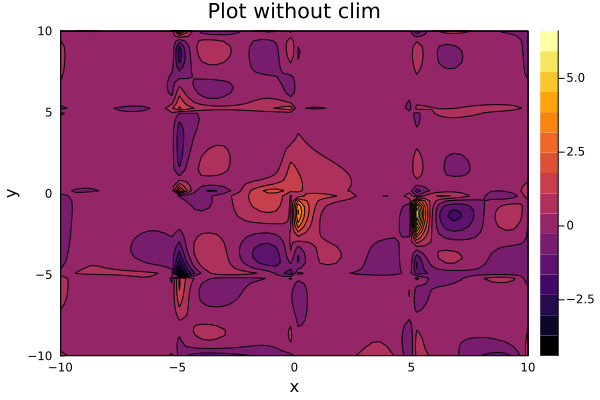

In [60]:
c_vec = A(c_vec)
println(norm(c_vec))
place_c_vec!(u_p, c_vec, center)
i += 1
println("A^$i(c_vec)")
plot_mps(u_p[1], R, 6, xmin, xmax, ymin, ymax)